In [1]:
%matplotlib inline

import sys
import pickle
from tester import test_classifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

/home/yannis/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Understanding the Dataset

## Features

***
**Salary Features**

| Payments            | Definitions of Category Groupings                                                                                                                                                                                                                                                                                                                                                                                                |
|---------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| ***Salary***              | Reflects items such as base salary, executive cash allowances, and benefits payments.                                                                                                                                                                                                                                                                                                                                            |
| ***Bonus***               | Reflects annual cash incentives paid based upon company performance. Also may include other retention payments.                                                                                                                                                                                                                                                                                                                  |
| ***Long Term Incentive*** | Reflects long-term incentive cash payments from various long-term incentive programs designed to tie executive compensation to long-term success as measuredagainst key performance drivers and business objectives over a multi-year period, generally 3 to 5 years.                                                                                                                                                            |
| ***Deferred Income***     | Reflects voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives as well as cash fees deferred by non-employee directorsunder a deferred compensation arrangement. May also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement.                                                                                                                     |
| ***Deferral Payments***   | Reflects distributions from a deferred compensation arrangement due to termination of employment or due to in-service withdrawals as per plan provisions.                                                                                                                                                                                                                                                                        |
| ***Loan Advances***       | Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment. In certain instances, the terms of thepromissory notes allow for the option to repay with stock of the company.                                                                                                                                                                                       |
| ***Other***               | Reflects items such as payments for severence, consulting services, relocation costs, tax advances and allowances for employees on international assignment (i.e.housing allowances, cost of living allowances, payments under Enron’s Tax Equalization Program, etc.). May also include payments provided with respect toemployment agreements, as well as imputed income amounts for such things as use of corporate aircraft. |
| ***Expenses***            | Reflects reimbursements of business expenses. May include fees paid for consulting services.                                                                                                                                                                                                                                                                                                                                     |
| ***Director Fees***       | Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors.                                                                                                                                                                                                                                                                                                                     |
| ***Total Payments***      | Sum of the above values                                                                                                                                                                                                                                                                                                                                                                                                         |
***

**Stock Features**

| Stock Value              | Definitions of Category Groupings                                                                                                                                                                                                                                                                                                                                                       |
|--------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| ***Exercised Stock Options***  | Reflects amounts from exercised stock options which equal the market value in excess of the exercise price on the date the options were exercised either throughcashless (same-day sale), stock swap or cash exercises. The reflected gain may differ from that realized by the insider due to fluctuations in the market price andthe timing of any subsequent sale of the securities. |
| ***Restricted Stock***         | Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vestingperiods, regardless of whether deferred.                                                                                                                                                                             |
| ***Restricted StockDeferred*** | Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement.                                                                                                                                                                                                                                                                     |
| ***Total Stock Value***        | Sum of the above values                                                                                                                                                                                                                                                                                                                                                                 |
***

**email features**

| Variable                      | Definition                                                                    |
|-------------------------------|-------------------------------------------------------------------------------|
| ***to messages***             | Total number of emails received (person's inbox)                              |
| ***email address***           | Email address of the person                                                   |
| ***from poi to this person*** | Number of emails received by POIs                                             |
| ***from messages***           | Total number of emails sent by this person                                    |
| ***from this person to poi*** | Number of emails sent by this person to a POI.                                |
| ***shared receipt with poi*** | Number of emails addressed by someone else to a POI where this person was CC. |

## Data Exploration 

In [2]:
### Load the dictionary containing the dataset
with open("./final_project_dataset.pkl", "rb") as data_file:
    data_init = pickle.load(data_file)

#Converting the dataset from a python dictionary to a pandas dataframe
data_df = pd.DataFrame.from_dict(data_init, orient='index')
data_df.shape

(146, 21)

The dataset contains information across 21 variables for 146 employees.  

Let's see how much information we have for each variable.

In [3]:
data_df.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955,2902,2869717,4484442,NaN,4175000,phillip.allen@enron.com,-126027,-3081055,1729541,...,47,1729541,2195,152,65,False,304805,1407,126027,NaN
BADUM JAMES P,NaN,NaN,178980,182466,NaN,NaN,NaN,NaN,NaN,257817,...,NaN,257817,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,NaN,NaN,james.bannantine@enron.com,-560222,-5104,5243487,...,39,4046157,29,864523,0,False,NaN,465,1757552,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,frank.bay@enron.com,-82782,-201641,63014,...,NaN,NaN,NaN,69,NaN,False,NaN,NaN,145796,NaN


There are some NaNs in the dataset. Let's see how much info we have on each feature.

In [4]:
data_df.count()

salary                       146
to_messages                  146
deferral_payments            146
total_payments               146
loan_advances                146
bonus                        146
email_address                146
restricted_stock_deferred    146
deferred_income              146
total_stock_value            146
expenses                     146
from_poi_to_this_person      146
exercised_stock_options      146
from_messages                146
other                        146
from_this_person_to_poi      146
poi                          146
long_term_incentive          146
shared_receipt_with_poi      146
restricted_stock             146
director_fees                146
dtype: int64

It seems that the NaNs are actually strings. I will transform them to NumPy's NaNs so i can count the actual data.

In [5]:
data_df.replace(to_replace='NaN', value=np.nan, inplace=True)

In [6]:
data_df.count()

salary                        95
to_messages                   86
deferral_payments             39
total_payments               125
loan_advances                  4
bonus                         82
email_address                111
restricted_stock_deferred     18
deferred_income               49
total_stock_value            126
expenses                      95
from_poi_to_this_person       86
exercised_stock_options      102
from_messages                 86
other                         93
from_this_person_to_poi       86
poi                          146
long_term_incentive           66
shared_receipt_with_poi       86
restricted_stock             110
director_fees                 17
dtype: int64

We can see that there are some variables like *Total Payments* and *Total Stock Value* that we have values for most of the employees in the dataset but some others like *Loan Advances* and *Director Fees* that we have information for too few employees.  

By paying attention to [Payments to Insiders statement](https://github.com/udacity/ud120-projects/blob/master/final_project/enron61702insiderpay.pdf), we can see that the values are summed both horizontally and vertically. This means that wherever there isn't a value it doesn't mean that we don't know the number but that the number is "0". Also since on the email fields there is not any "0" value, I assume also that a missing value means "0" emails.  
Based on this, I will replace all the NaN values on numerical fields with "0".

In [7]:
data_df.dtypes

salary                       float64
to_messages                  float64
deferral_payments            float64
total_payments               float64
loan_advances                float64
bonus                        float64
email_address                 object
restricted_stock_deferred    float64
deferred_income              float64
total_stock_value            float64
expenses                     float64
from_poi_to_this_person      float64
exercised_stock_options      float64
from_messages                float64
other                        float64
from_this_person_to_poi      float64
poi                             bool
long_term_incentive          float64
shared_receipt_with_poi      float64
restricted_stock             float64
director_fees                float64
dtype: object

In [8]:
data_df.replace(to_replace=np.nan, value=0, inplace=True)
data_df.email_address.replace(to_replace=0, value=np.nan, inplace=True)

## Outlier Investigation

You may notice that there are two aggregated features in the dataset:

* Total Payments
* Total Stock Value

For these two features we have also the most information so initially, I will use these two features for outliers investigation.

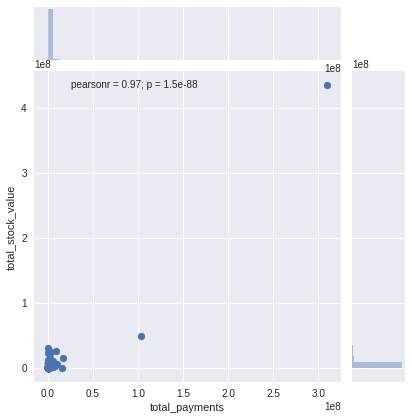

In [9]:
sns.jointplot(x="total_payments", y="total_stock_value", data=data_df)

We can see two datapoints very far from the rest.

In [10]:
data_df.total_payments.nlargest(2)

TOTAL            309886585.0
LAY KENNETH L    103559793.0
Name: total_payments, dtype: float64

The first one 'TOTAL', is the totals on the [financial statement](./enron61702insiderpay.pdf) and not a person so it should be removed.  
The second one is not an outlier, it is just the huge payment and stock value of the CEO and chairman of Enron, Kenneth Lay. Datapoints like this are not outliers; in fact anomalies like this may lead us to the rest of the POIs. 
These extreme values lead the rest of the employees to the bottom left corner of the scatterplot. Let's use a logarithmic scale for both axes to unclutter the plot.

In [11]:
data_df.drop("TOTAL", inplace=True)

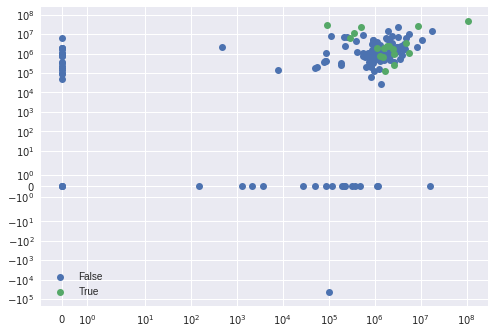

In [12]:
fig, ax = plt.subplots()
for poi, data in data_df.groupby(by="poi"):
    ax.plot(data['total_payments'],data['total_stock_value'],'o', label=poi)
ax.legend()
plt.xscale('symlog')
plt.yscale('symlog')

plt.show()

From this scatterplot we can see that there are not POIs with Total Payments less than 91,000 dollars or Total Stock Value less than 126,000 dollars.

Let's have a look in email variables for any outliers.

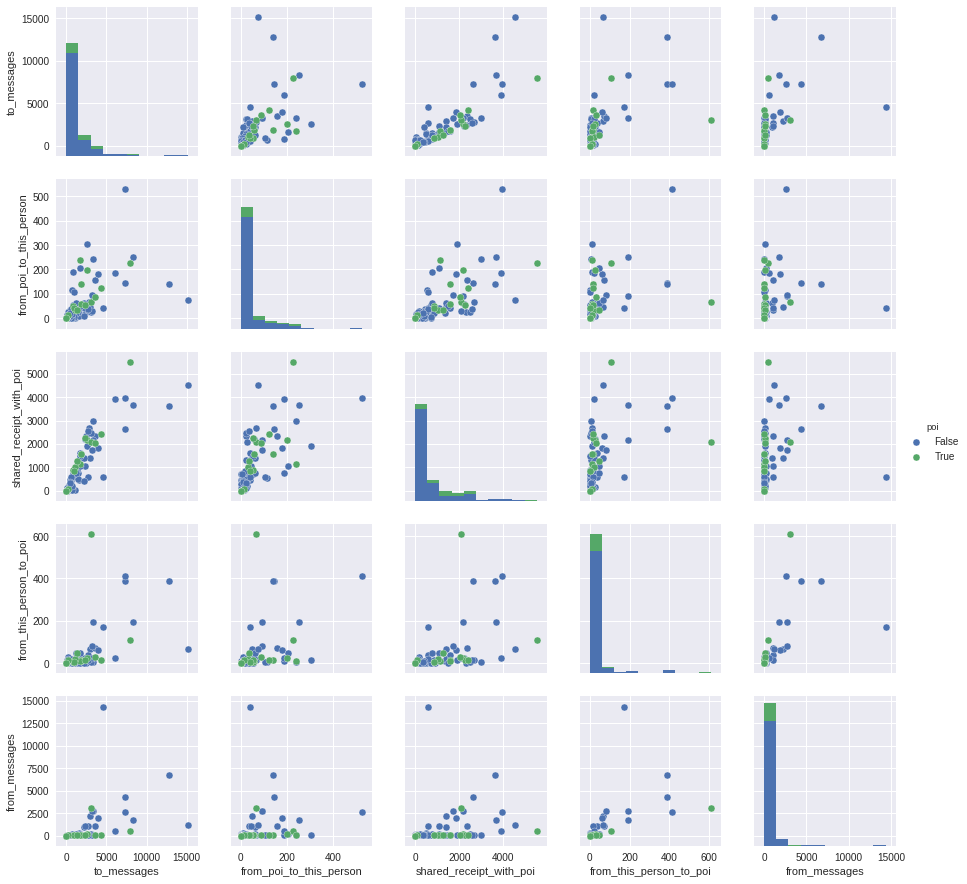

In [13]:
sns.pairplot(
    data_df[[
        "poi", "to_messages", "from_poi_to_this_person",
        "shared_receipt_with_poi", "from_this_person_to_poi", "from_messages"
    ]],
    vars=[
        "to_messages", "from_poi_to_this_person", "shared_receipt_with_poi",
        "from_this_person_to_poi", "from_messages"
    ],
    hue="poi", kind="scatter")

There are some high values but we cannot say there is any obvious outlier.  
With a closer look we can see that there is some clustering when we plot from_messages with other email variables, especially with "from_this_person_to_poi". I will investigate it further in the new feature creation section.  

Before going any further I will run an initial classification model so I can use the results as a baseline to evaluate improvements during the project.  
I will split the dataset to training and testing and i will use a simple classifier (LinearSVC) which seems appropriate for the problem and further in the analysis I will try more sophisticated classifiers.

In [14]:
def prepare_dataset(data_df):
    #Dropping the email feature because because it is irrelevant
    X = data_df.drop("email_address", axis=1)
    # Transform the 'poi' from True / False to 0 / 1
    X.poi = X.poi.astype(int)
    #Removing the poi labels and put them in a separate array
    y = X.pop("poi")
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    data_train = pd.concat([y_train, X_train], axis=1)
    data_test = pd.concat([y_test, X_test], axis=1)
    
    return X_train, X_test, y_train, y_test, data_train, data_test

In [15]:
X_train, X_test, y_train, y_test, data_train, data_test = prepare_dataset(data_df)

In [16]:
#test_classifier() demands the dataset in a dictionary and the features labels
#in a list with 'poi' first.
features = data_train.columns.tolist()
data = data_train.to_dict(orient='index')

test_classifier(svm.LinearSVC(random_state=42), data, features)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)
	Accuracy: 0.72436	Precision: 0.12287	Recall: 0.33100	F1: 0.17921	F2: 0.24724
	Total predictions: 11000	True positives:  331	False positives: 2363	False negatives:  669	True negatives: 7637



# Optimize Feature Selection/Engineering

## Create new features

In the previous section we noticed a weak clustering while we were plotting pairs of features. This may be useful for new feature creation because if we create a new variable by dividing the two features there will be a value separation between the two classes.  

By examining all the different combinations using pairplots, I concluded that POIs have a lower ratio of Restricted Stock to Total Stock Value and a higher rate of exchanged emails with POIs.

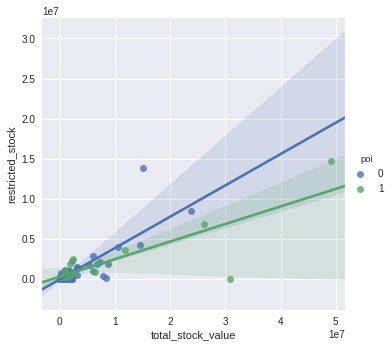

In [17]:
sns.lmplot(
    x="total_stock_value", y="restricted_stock", data=data_train, hue="poi")

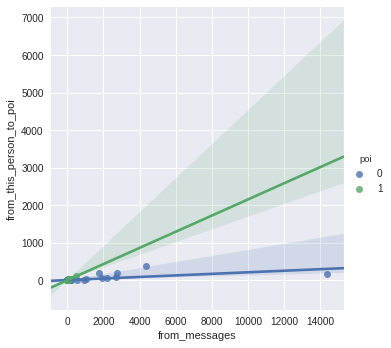

In [18]:
sns.lmplot(
    x="from_messages", y="from_this_person_to_poi", data=data_train, hue="poi")

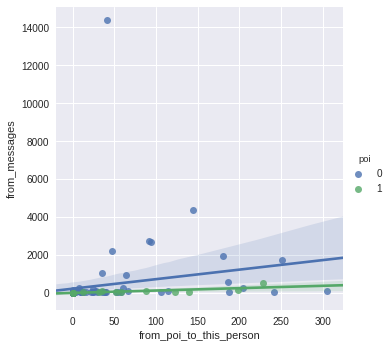

In [19]:
sns.lmplot(
    x="from_poi_to_this_person", y="from_messages", data=data_train, hue="poi")

We can create three new variables that will represent these ratios.

In [20]:
data_train["stock_ratio"] = data_train["restricted_stock"] / data_train[
    "total_stock_value"]
data_train["to_poi_vs_from"] = data_train["from_this_person_to_poi"] / data_train[
    "from_messages"]
data_train["from_poi_vs_from"] = data_train["from_poi_to_this_person"] / data_train[
    "from_messages"]
data_train.replace(to_replace=np.nan, value=0, inplace=True)

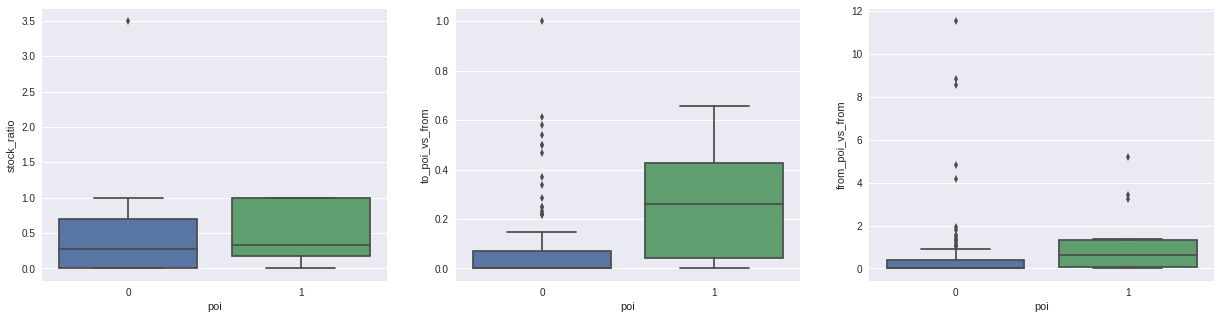

In [21]:
plt.subplots(figsize=(21, 5))

plt.subplot(131)

boxplot1 = sns.boxplot(x="poi", y="stock_ratio", data=data_train)

plt.subplot(132)

boxplot2 = sns.boxplot(x="poi", y="to_poi_vs_from", data=data_train)

plt.subplot(133)

boxplot3 = sns.boxplot(x="poi", y="from_poi_vs_from", data=data_train)

plt.show()

The statistics are against our intuition for the "stock_ratio" feature but they confirm our intuition for the other two.

In [22]:
data_df["to_poi_vs_from"] = data_df["from_this_person_to_poi"] / data_df[
    "from_messages"]
data_df["from_poi_vs_from"] = data_df["from_poi_to_this_person"] / data_df[
    "from_messages"]
data_df.replace(to_replace=np.nan, value=0, inplace=True)
X_train, X_test, y_train, y_test, data_train, data_test = prepare_dataset(data_df)

## Feature Selection

For feature selection I will use LinearSVC classifier and I will test both univariate feature selection (KBest) and primary component analysis. For the number of features I will start with 2 and try up to 10.

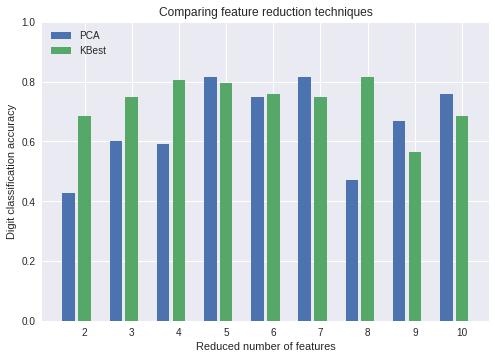

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipe = Pipeline([
    ('reduce_dim', PCA(random_state=42)),
    ('classify', svm.LinearSVC(random_state=42))
])

N_FEATURES_OPTIONS = list(range(2,11))

param_grid = [
    {
        'reduce_dim': [PCA(random_state=42)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
    },
]
reducer_labels = ['PCA', 'KBest']
grid = GridSearchCV(pipe, param_grid=param_grid)

grid.fit(X_train, y_train)
mean_scores = np.array(grid.cv_results_['mean_test_score'])
mean_scores = mean_scores.reshape(-1, len(N_FEATURES_OPTIONS))
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + .5)
plt.figure()

for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label)

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')
plt.show()

We can see that univariate selection give us a good result with just 4 features. Further addition either gives us worse or similar score.  
If we analyze the dataset to primary components we should analyze it to 5 components.  

Let's try our scoring function with both options.

In [68]:
clf = SelectKBest(k=4)
a = clf.fit(X_train, y_train)
X_new = X_train[X_train.columns[a.get_support()]]
data = pd.concat([pd.DataFrame(y_train), X_new], axis=1)
features = list(data.columns)
data = data.to_dict(orient='index')

test_classifier(svm.LinearSVC(random_state=42), data, features)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)
	Accuracy: 0.65900	Precision: 0.10310	Recall: 0.31300	F1: 0.15510	F2: 0.22243
	Total predictions: 10000	True positives:  313	False positives: 2723	False negatives:  687	True negatives: 6277



In [88]:
pca = PCA(n_components=5)
data = pca.fit_transform(X_train)
data = pd.DataFrame(data, index=X_train.index)
data = pd.concat([pd.DataFrame(y_train), data], axis=1)
features = list(data.columns)
data = data.to_dict(orient='index')

test_classifier(svm.LinearSVC(random_state=42), data, features)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)
	Accuracy: 0.77300	Precision: 0.13110	Recall: 0.26600	F1: 0.17564	F2: 0.22060
	Total predictions: 11000	True positives:  266	False positives: 1763	False negatives:  734	True negatives: 8237



# Draft

In [87]:
data

,poi,0,1,2,3,4
HAUG DAVID L,0,-2.879404e+06,-4.082923e+05,1.392197e+06,-1.854211e+06,2.412175e+05
HUGHES JAMES A,0,-3.307663e+06,-9.248576e+05,-5.224052e+05,-8.317697e+05,2.472511e+05
MULLER MARK S,0,-7.991676e+05,-1.687673e+06,4.105148e+05,1.651017e+06,-3.113938e+05
REDMOND BRIAN L,0,1.339864e+06,7.225280e+06,-2.356713e+06,-5.323687e+05,3.126382e+05
MORDAUNT KRISTINA M,0,-3.446441e+06,-2.178861e+06,-2.818877e+05,-4.110081e+05,-2.507336e+04
SAVAGE FRANK,0,-3.998213e+06,-2.119289e+06,-6.375166e+05,-6.365208e+05,2.385271e+05
ALLEN PHILLIP K,0,5.082647e+05,-1.528681e+06,1.018729e+06,4.254226e+06,-2.179225e+06
HIRKO JOSEPH,1,1.683881e+07,3.508982e+07,-9.167449e+06,5.536272e+05,5.591794e+05
COX DAVID,0,-2.932712e+06,-2.070567e+06,5.248049e+03,-1.511554e+05,-3.988822e+05
ECHOLS JOHN B,0,-1.469581e+06,-2.042849e+06,2.328062e+05,7.723924e+05,1.910636e+05


In [82]:
pd.DataFrame(y_train)

,poi
HAUG DAVID L,0
HUGHES JAMES A,0
MULLER MARK S,0
REDMOND BRIAN L,0
MORDAUNT KRISTINA M,0
SAVAGE FRANK,0
ALLEN PHILLIP K,0
HIRKO JOSEPH,1
COX DAVID,0
ECHOLS JOHN B,0


In [31]:
selector = SelectKBest(k=4)
a = selector.fit(X_train, y_train)

In [32]:
list(X_train.columns[a.get_support()])

['bonus', 'total_stock_value', 'exercised_stock_options', 'to_poi_vs_from']

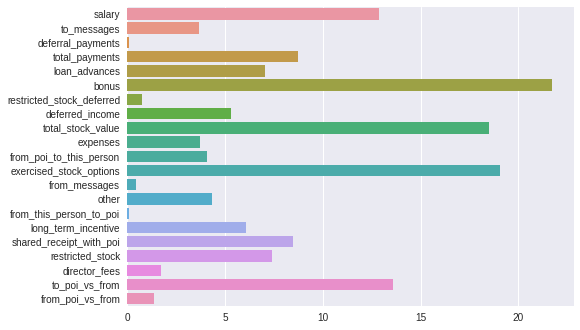

In [30]:
sns.barplot(y=X_train.columns, x=a.scores_)

In [94]:
X_train = X_train[X.columns[selector.get_support()]]
X_test = X_test[X.columns[selector.get_support()]]

NameError: name 'X' is not defined

## Features Scaling

In [47]:
X_train = preprocessing.scale(X_train)

In [49]:
X_train = pd.DataFrame(X_train, columns=selected_features)

In [50]:
X_train.describe()

,salary,bonus,total_stock_value,exercised_stock_options,to_poi_vs_from
count,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02
mean,5.551115e-17,7.607084e-17,1.541976e-17,5.139921e-17,1.233581e-17
std,1.004662e+00,1.004662e+00,1.004662e+00,1.004662e+00,1.004662e+00
min,-8.830784e-01,-5.650144e-01,-4.494847e-01,-4.111603e-01,-5.739670e-01
25%,-8.830784e-01,-5.650144e-01,-4.120680e-01,-4.111603e-01,-5.739670e-01
50%,6.597181e-02,-3.065347e-01,-3.063009e-01,-3.142502e-01,-5.739670e-01
75%,3.677707e-01,1.242648e-01,-1.376565e-01,-1.000643e-01,2.258695e-01
max,4.375501e+00,5.466178e+00,6.835559e+00,6.244559e+00,4.630019e+00


# Algorithm Selection and Tuning

## Algorithm Selection

In [51]:
clf = svm.LinearSVC(random_state=42)
scores = cross_val_score(clf, X_train, y_train)
print(scores.mean())

0.871078221078


In [52]:
clf = KNeighborsClassifier()
scores = cross_val_score(clf, X_train, y_train)
print(scores.mean())

0.841991991992


In [53]:
clf = GradientBoostingClassifier(random_state=42)
scores = cross_val_score(clf, X_train, y_train)
print(scores.mean())

0.842256542257


In [54]:
clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(clf, X_train, y_train)
print(scores.mean())

0.870563420563


## Algorithm Tuning

In [102]:
def find_optimal(min_bound, max_bound):
    while min_bound < max_bound:
        b = round((min_bound+max_bound)/2)
        print(min_bound, b, max_bound)
        tune_parameters = [{'n_estimators': [min_bound,b,max_bound]}]
        
        clf = GridSearchCV(RandomForestClassifier(random_state=42), tune_parameters)
    
        clf.fit(X_train, y_train)
        best_param = clf.best_params_['n_estimators']
        
        if (best_param == min_bound):
            max_bound = b
        elif (best_param == max_bound):
            min_bound = b
        else:
            min_bound = round((b+min_bound)/2)
            max_bound = round((max_bound+b)/2)
            
    print(clf.best_params_)
    print(clf.best_score_)
    
find_optimal(1,1000)

1 500 1000
500 750 1000
750 875 1000
875 938 1000
906 938 969
922 938 954
922 930 938
922 926 930
922 924 926
922 923 924
922 922 923
{'n_estimators': 922}
0.861111111111


In [90]:
find_optimal(1,1000)

{'n_estimators': 1000}
0.861111111111


In [73]:
tune_parameters = [{'C': [0.01, 0.1, 1, 10, 100]}]

clf = GridSearchCV(svm.LinearSVC(dual=False, random_state=42), tune_parameters)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'C': 0.1}
0.87962962963


In [92]:
clf.best_params_['C']

0.1

In [97]:
tune_parameters = [{'n_estimators': [1, 10, 1000]}]

clf = GridSearchCV(RandomForestClassifier(random_state=42), tune_parameters)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'n_estimators': 10}
0.87037037037


In [58]:
clf = svm.LinearSVC(C=10, dual=False, random_state=42)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

0.243243243243


In [59]:
clf = RandomForestClassifier(n_estimators=10, random_state=42)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

0.540540540541


# Draft

In [49]:
poi_list = []
npoi_list = []
result = pd.DataFrame(columns=["Feature 1", "Feature 2", "Ratio"])
features = data_df.columns.tolist()
features.remove("email_address")
for feature1 in features:
    for feature2 in features:
        for employee in data_df.iterrows():
            try:
                value = employee[1][feature1] / employee[1][feature2]
            except ZeroDivisionError:
                break
            except TypeError:
                print(feature1, feature2)

            if employee[1]["poi"]:
                poi_list.append(value)
            else:
                npoi_list.append(value)
        if len(poi_list) > 0 and len(npoi_list) > 0:
            value1 = (sum(poi_list) / len(poi_list)) / (sum(npoi_list) /
                                                        len(npoi_list))
            result = result.append(
                pd.DataFrame(
                    [[feature1, feature2, value1]],
                    columns=["Feature 1", "Feature 2", "Ratio"]))

In [50]:
result.sort_values("Ratio", ascending=False)

,Feature 1,Feature 2,Ratio
0,salary,total_stock_value,0.064570
0,salary,expenses,0.048617
0,salary,deferred_income,0.045984
0,salary,restricted_stock_deferred,0.044175
0,salary,bonus,0.041490
0,salary,total_payments,0.039788
0,salary,loan_advances,0.039788
0,salary,from_messages,0.001469
0,salary,exercised_stock_options,0.001468
0,salary,from_poi_to_this_person,0.001340


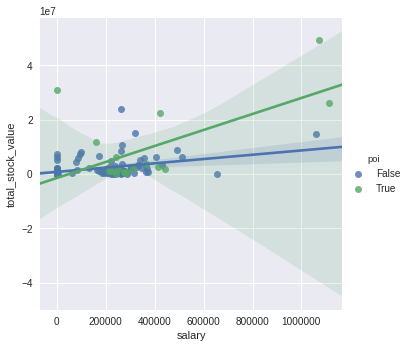

In [51]:
sns.lmplot(
    x="salary", y="total_stock_value", data=data_df, hue="poi")

In [102]:
result = pd.DataFrame(columns=["Feature 1", "Feature 2", "Ratio"])
addition = pd.DataFrame([["Arxidia", "Poutses", 7]], columns=["Feature 1", "Feature 2", "Ratio"])
result = result.append(addition)
result

,Feature 1,Feature 2,Ratio
0,Arxidia,Poutses,7.0
